#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot

In [21]:
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [22]:
d, Nobs = 15, 100
p = 1e-1
X = rand(Normal(), d, Nobs) .* rand(Binomial(1,p), d, Nobs)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,0.5), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = 10
σ02 = 1

# prior = HS_prior(d, σ02)
# prior = GDP_prior(d, σ02)
prior = gaussian_prior_nh(zeros(d), 10*rand(d))

gaussian_prior_nh([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.16748, 0.702171, 8.48018, 0.700307, 3.27566, 9.25404, 6.60853, 8.44162, 8.88939, 1.67815, 5.96104, 9.33054, 7.56836, 1.81051, 1.96678])

In [23]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [24]:
# Sub-Sampling without control variate and with weights
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

In [44]:
A = eye(d)
adapt_speed = true
opf = projopf(A, 100, adapt_speed, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt);

In [45]:
outp.opf.adapt_speed

true

In [46]:
bb = linear_bound(my_model.ll, my_model.pr, gs_list, zz_state(opf))
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [47]:
print("Speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [48]:
my_zz_sampler = zz_sampler(0, gs_list, bb)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [49]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

2.05 mins

In [51]:
size(outp.opf.alpha_skeleton)

(15, 91560)

In [52]:
size(outp.opf.xi_skeleton)

(15, 91560)

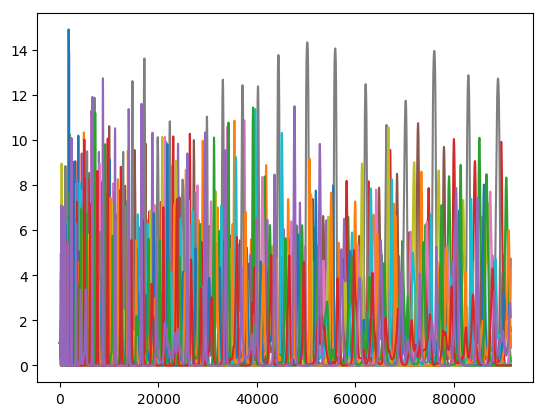

In [53]:
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end

In [54]:
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton, 
                             outp.opf.bt_skeleton, 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton, 
                                outp.opf.bt_skeleton, 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

In [55]:
[compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d]

15-element Array{Float64,1}:
 0.813903
 0.997358
 0.956624
 0.91303 
 0.987795
 1.0953  
 0.945393
 0.658977
 1.01883 
 0.607984
 0.895024
 0.926147
 0.844354
 1.08261 
 1.16553 

In [56]:
outp.opf.n_bounces

15-element Array{Int64,1}:
 5600
 5692
 5747
 5670
 5566
 5628
 5531
 5647
 5521
 5586
 5704
 5744
 5518
 5539
 5647